In [1]:
import sys
import torch
sys.path.append("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample")
from src.log_likelihood import LogLikelihoodMonteCarlo
from datasets.Regression.toydataset import create_dataset, sinus_mapping, dataset_to_loader, visualize_predictions, to_loader
from src.network.feature_extractor import FC_Net
from src.network import LikApprox
from torch import nn
from backpack import backpack, extend
from backpack.extensions import DiagHessian, DiagGGNExact, DiagGGNMC
from torch.autograd import grad
from tqdm import tqdm
from src.laplace import LaplaceVI
from matplotlib import pyplot as plt
import copy

torch.manual_seed(3)

data_noise = 0.2
n_datapoints = 256
x_train, y_train, x_test, y_test = create_dataset(lower=-5, upper=7, mapping=sinus_mapping,cluster_pos=[-0.5, 2], data_noise=data_noise, n_datapoints=n_datapoints)
batch_size = 16
train_set, test_set = dataset_to_loader(x_train, y_train, x_test, y_test , batch_size=16)

### Parameters

In [2]:
lr = 1e-3
epochs = 500
tau = 10

### Model definition

In [3]:
feature_extractor = torch.nn.Sequential(
        torch.nn.Linear(1, 100),
        torch.nn.Tanh(),
        torch.nn.Linear(100, 200),
        torch.nn.Tanh()
)
model = LaplaceVI(200, 1, feature_extractor, tau=tau, lr=lr)
baseline_model = copy.deepcopy(model)
baseline_model.tau = 0

### Training

In [4]:
tracking_baseline, trajectories_baseline = baseline_model.train_model_with_trajectories(train_set, n_datapoints, epochs);
tracking_la, trajectories_la = model.train_model_with_trajectories(train_set, n_datapoints, epochs);

loss:0.13 entropy:704.31: 100%|██████████| 500/500 [00:45<00:00, 11.05it/s]


### Plotting

In [5]:

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

def plot_trajectories(traj, axs, splits, labels=("Baseline", "Laplace"), color=["red", "blue"]):
    pca = PCA(n_components=2)
    projection = pca.fit_transform(traj)
    for idx, (start, end) in enumerate(zip([0]+splits, splits+[2*epochs-1])):
        axs.scatter(projection[start:end, 0], projection[start:end, 1], s=1, label=labels[idx], color=color[idx], zorder=10)
        mid = start+int((end-start)/2)
        axs.arrow(projection[mid][0], projection[mid][1], (projection[mid+1] - projection[mid])[0], (projection[mid+1] - projection[mid])[1])
    return projection, pca

@torch.no_grad()
def plot_loss(pca:PCA, baseline_model:LaplaceVI, x_bounds, y_bounds, dataset, axs, steps=10):
    loss_fun = torch.nn.MSELoss(reduction="sum")
    old_params = baseline_model.ll_model[-1].weight.data.detach().clone()
    x_lin = torch.linspace(x_bounds[0], x_bounds[1], steps=steps)
    y_lin = torch.linspace(y_bounds[0], y_bounds[1], steps=steps)
    loss_grid = torch.zeros((steps, steps))
    for idx, x in enumerate(x_lin):
        for idy, y in enumerate(y_lin):
            new_weights = pca.inverse_transform(torch.tensor([x,y]))
            baseline_model.ll_model[-1].weight.data = torch.unsqueeze(torch.from_numpy(new_weights).float(), dim=0)
            for data, target in dataset:
                loss_grid[idx, idy] += loss_fun(baseline_model(data), target)
    loss_grid /= n_datapoints
    baseline_model.ll_model[-1].weight.data = old_params
    return axs.contourf(x_lin, y_lin, loss_grid, zorder=0, alpha=0.5)


        
    

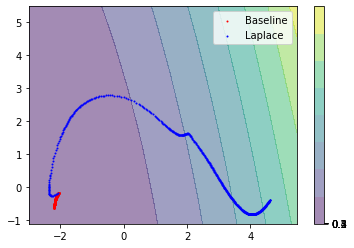

In [6]:
from matplotlib import pyplot as plt
# from src.utils.plotting import plot_trajectories
fig, axs = plt.subplots(1)
projection, pca = plot_trajectories(torch.cat([trajectories_baseline, trajectories_la], dim=0), axs,
 splits = [epochs]);
axs.legend()
expansion = 1.1
cmap = plot_loss(pca, baseline_model, (axs.get_xlim()[0]*expansion,axs.get_xlim()[1]*expansion), (axs.get_ylim()[0]*expansion, axs.get_xlim()[1]*expansion), train_set, axs, steps=20)
fig.colorbar(cmap, ax=axs, ticks=[0.1, 0.2, 0.3, 0.4, 0.5])